In [1]:
import parselmouth
import matplotlib.pyplot as plt
import numpy as np
import re
from itertools import pairwise, product

from src.words import (
    NumberWord,
    Word,
    is_number_notes_string,
    notes_string_to_number,
    get_prevalence,
)
from src.audio_io import record, play
from src.whistle_analysis import (
    analyse_recording_to_notes,
    determine_pause_lengths,
    determine_pause_thresholds,
    determine_bounds_for_notes_in_recording,
)
from src.note import Note, turn_into_notes_strings
from src.my_types import segbounds
from src.constants import SAMPLE_RATE, SAMPLE_RATE_PARSELMOUTH
from src.wave_generation import DURATION
from src.augmentation import Augmentation
from src.file_management import load_words_from_folder

In [2]:
%matplotlib inline

In [3]:
recording = record(5)

Recording...
Recording complete.


In [4]:
play(recording)

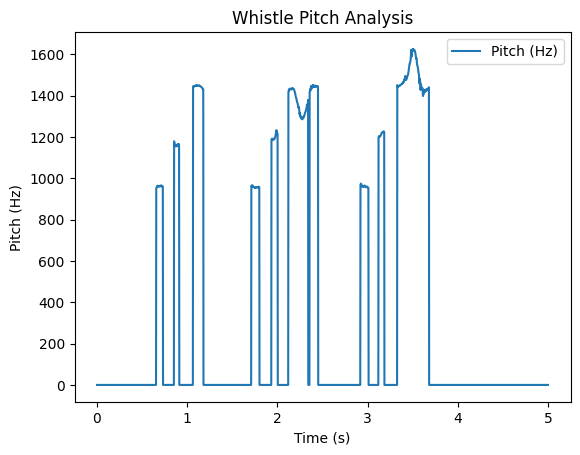

In [5]:
sampling_rate = 44100

# Create a Parselmouth Sound object from the array
snd = parselmouth.Sound(recording, sampling_frequency=sampling_rate)

# Analyze pitch
pitch = snd.to_pitch_ac(pitch_floor=300, pitch_ceiling=4000, silence_threshold=0.1)
pitch_values = pitch.selected_array['frequency']

# Plot pitch
plt.plot(pitch.xs(), pitch_values, label='Pitch (Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Whistle Pitch Analysis')
plt.legend()
plt.show()

In [6]:
notes_from_recording, segment_bounds, offset = analyse_recording_to_notes(recording)

In [7]:
strings_from_recording = turn_into_notes_strings(notes_from_recording)
for s in strings_from_recording:
    print(s)

0:3:7
0:4:7*
0:4:7^


In [8]:
play(pitch.to_sound_sine()) # type: ignore

In [9]:
from src.whistle_analysis import (
    find_closest_sentence_for_notes_strings,
    get_synthesised_versions_of_words,
    merge_into_one_wave,
)

words_from_recording: list[Word | None] = find_closest_sentence_for_notes_strings(strings_from_recording)
words_from_recording

[pakala, tawa (comparative), tawa (superlative)]

In [10]:
synthesised_version_of_words = get_synthesised_versions_of_words(
    words_from_recording, notes_from_recording, segment_bounds, offset
)

full_wave = merge_into_one_wave(
    synthesised_version_of_words, notes_from_recording, len(recording), segment_bounds
)

In [11]:
from src.my_types import floatlist
from src.whistle_analysis import freqs_to_float_pitches

def plot_with_target(recording: floatlist, synthesised_version: floatlist):
    snd_recording = parselmouth.Sound(recording, sampling_frequency=SAMPLE_RATE)  # type: ignore
    pm_recording = snd_recording.to_pitch_ac(pitch_floor=300, pitch_ceiling=4000, silence_threshold=0.1)  # type: ignore
    frequencies_recording = np.array(pm_recording.selected_array["frequency"], dtype=float)  # type: ignore
    pitch_recording = freqs_to_float_pitches(frequencies_recording) - offset

    snd_synth = parselmouth.Sound(synthesised_version, sampling_frequency=SAMPLE_RATE)  # type: ignore
    pm_synth = snd_synth.to_pitch_ac(pitch_floor=300, pitch_ceiling=4000, silence_threshold=0.1)  # type: ignore
    frequencies_synth = np.array(pm_synth.selected_array["frequency"], dtype=float)  # type: ignore
    pitch_synth = freqs_to_float_pitches(frequencies_synth) + 12 - offset

    # Plot pitch
    plt.plot(pm_recording.xs(), pitch_recording, label="Recording")  # type: ignore
    plt.plot(pm_recording.xs(), pitch_synth, label="Target")  # type: ignore
    plt.xlabel("Time (s)")  # type: ignore
    plt.ylabel("Pitch (semitones)")  # type: ignore
    plt.title("Whistle Pitch Analysis")  # type: ignore
    plt.legend()  # type: ignore
    fig, _ = plt.subplots()  # type: ignore
    st.pyplot(fig)

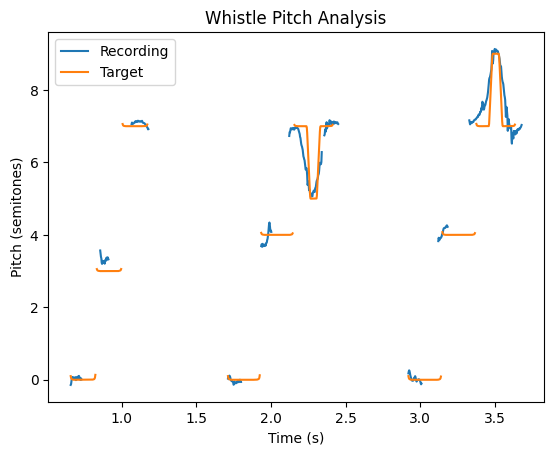

In [12]:
plot_with_target(recording, full_wave)

In [13]:
from src.whistle_analysis import extract_individual_words_from_recording


individual_words_in_recording = extract_individual_words_from_recording(recording, notes_from_recording, segment_bounds)

play(individual_words_in_recording[1])